In [113]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np

black = (0,0,0,1)
green = (0, 0, 1, 1)
blue = (0,1,0,1)

xMax = 1
yMax = 1
zMax = 1
    
    
def drawLabel((x,y,z),label):
    ax.text(x,y,z, label)

def arrow( (x,y,z), (u,v,w), label, color):  
    ax.quiver(x,y,z, u,v,w, arrow_length_ratio=.1,\
              colors=[color], linewidths=[2])
    ex,ey,ez = x+u, y+v, z+w
    drawLabel((ex,ey,ez), label)

    global xMax, yMax, zMax
    xMax = np.max([x, ex, xMax])
    yMax = np.max([y, ey, yMax])
    zMax = np.max([z, ez, zMax])


    

In [114]:
# Fixed Frame A
A = np.eye(3) # identity matrix
E1, E2, E3 = A
rO = np.array((0,0,0))

# Moving Frame B
B = np.eye(3) # identity matrix
e1, e2, e3 = B 
rQ = np.array((10, 20, 5))

# moving point P observed in B
rPQ = np.array((5,5,0))

# point P observed in A?
rP = rQ  + rPQ



<IPython.core.display.Javascript object>


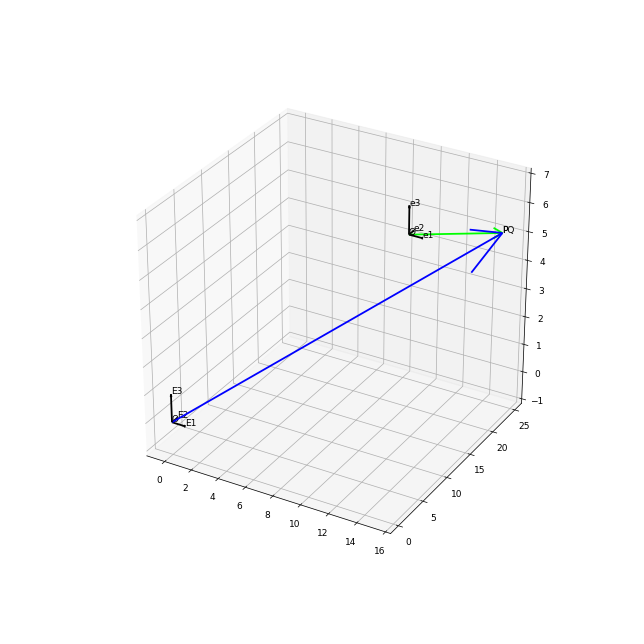

In [115]:
%matplotlib notebook  
plt.close('all')
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')



# plot frame A
arrow(rO, E1, 'E1', black)
arrow(rO, E2, 'E2', black)
arrow(rO, E3, 'E3', black)
drawLabel(rO, 'O')

#plot frame B
arrow(rQ, e1, 'e1', black)
arrow(rQ, e2, 'e2', black)
arrow(rQ, e3, 'e3', black)
drawLabel(rQ, 'Q')

#plot point P observed in B
arrow( rQ, rPQ, 'PQ', blue)

#plot point P observed in A
arrow( rO, rP, 'P', green)


ax.set_xlim3d(-1, xMax+1)
ax.set_ylim3d(-1, yMax+1)
ax.set_zlim3d(-1, zMax+1)

plt.show()

In [ ]:
def unit(v):
    return np.array(v)/np.linalg.norm(v)

def basis():
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    z = np.array([0,0,1])
    return x,y,z

class Point:
    def __init__(self, (x,y,z), frame):
        self.x = x
        self.y = y
        self.z = z
        self.pt = np.array((x,y,z))
        self.frame = frame
        
    def __iter__(self):
        for p in self.pt:
            yield p
    
    def __str__(self):
        return "Point in frame %s : (%.3f,%.3f,%.3f)" \
            % (self.frame, self.x, self.y, self.z)

print Point( (0,0,0), 'B')